This Notebook benchmarks read/write speeds and file sizes for different file types and compression algorithms.
i.e.:
- CSV + GZIP
- CSV + ZStandard
- CSV + ZStandard (level 10 compression)
- Parquet + Snappy
- Parquet + ZStandard

It is run on a ```Intel(R) Xeon(R) CPU E5-1650 v3 @ 3.50GHz``` / ```128GB RAM``` server with ```Ubuntu 22.04.1 LTS```.

NOTE: Here the files are being written to ```/dev/shm``` which is a RAM disk. This is to avoid the disk IO bottleneck. 
i.e. The results might be significantly slower when writing to HDD/SSD. Regardles, the file sizes and performance differences should be comparable.

### Methodology:
1. Load 100 random dataframes into a dictionary
2. Write each dataframe to a ```Parquet+Snappy```, ```Parquet+ZSTD```, ```CSV+GZIP```, ```CSV+ZSTD```, and ```CSV+ZSTD10``` file.

# **Visualized Results @ end of notebook**

In [2]:
import os
import pandas as pd
import lib.mb as mb
import lib.load as load
import time
import config
from pyarrow import parquet as pq, Table as pt

TEST_ROOT = os.path.join("/dev/shm/", "tests/")
os.makedirs(TEST_ROOT, exist_ok=True)

In [3]:
with open(
    os.path.join(config.SAMPLE_ROOT, 'random_file_paths.txt'), 'r') as f:
    paths = f.readlines()

paths = [path.strip() for path in paths]

# Loading Data

In [4]:
%%time
files_dict = {}

start_load = time.monotonic()
for i, path in enumerate(paths):
    files_dict[i] = pd.read_csv(path, sep='\t')
end_load = time.monotonic()

load_time = round(end_load - start_load, 2)
load_time

CPU times: user 3.25 s, sys: 305 ms, total: 3.55 s
Wall time: 3.55 s


3.55

# Write times

In [5]:
%%time
# Writing files in Parquet w/ snappy commpression

parquet_snappy_paths = []
os.makedirs(
    os.path.join(TEST_ROOT, "snappy_parquet/"), 
    exist_ok=True)


parquet_snappy_write_start = time.monotonic()

for n, df in files_dict.items():
    path =  os.path.join(TEST_ROOT, f"snappy_parquet/{n}_snappy.parquet")
    parquet_snappy_paths.append(path)
    df.to_parquet(path, compression='snappy')

parquet_snappy_write_end = time.monotonic()

parquet_snappy_write_time = round(parquet_snappy_write_end - parquet_snappy_write_start, 2)
parquet_snappy_write_time

CPU times: user 2.49 s, sys: 173 ms, total: 2.66 s
Wall time: 2.58 s


2.58

In [6]:
%%time
# writing files in parquet w/ zstd compression

parquet_zstd_paths = []
os.makedirs(
    os.path.join(TEST_ROOT, "zst_parquet/"), 
    exist_ok=True)

parquet_zstd_write_start = time.monotonic()

for n, df in files_dict.items():
    path =  os.path.join(TEST_ROOT, f"zst_parquet/{n}_zst.parquet")
    parquet_zstd_paths.append(path)
    
    df = pt.from_pandas(df)
    pq.write_table(df, path, compression='zstd')

parquet_zstd_write_end = time.monotonic()
parquet_zstd_write_time = round(parquet_zstd_write_end - parquet_zstd_write_start, 2)
parquet_zstd_write_time

CPU times: user 2.58 s, sys: 178 ms, total: 2.76 s
Wall time: 2.67 s


2.67

In [7]:
%%time
# writing files in CSV w/ GZIP compression

csv_gzip_paths = []
os.makedirs(
    os.path.join(TEST_ROOT, "gzip_csv/"),
    exist_ok=True)

csv_gzip_write_start = time.monotonic()
for n, file in enumerate(paths):
    df = pd.read_csv(file, sep='\t')
    path =  os.path.join(TEST_ROOT, f"gzip_csv/{n}_gzip.csv.zst")
    csv_gzip_paths.append(path)
    
    df.to_csv(path, compression='gzip')

csv_gzip_write_end = time.monotonic()
csv_gzip_write_time = round(csv_gzip_write_end - csv_gzip_write_start, 2)
csv_gzip_write_time

CPU times: user 35.3 s, sys: 264 ms, total: 35.6 s
Wall time: 35.6 s


35.59

In [8]:
%%time
# writing files in CSV w/ zstd compression

csv_zstd_paths = []
os.makedirs(
    os.path.join(TEST_ROOT, "zst_csv/"),
    exist_ok=True)

csv_zstd_write_start = time.monotonic()
for n, file in enumerate(paths):
    df = pd.read_csv(file, sep='\t')
    path =  os.path.join(TEST_ROOT, f"zst_csv/{n}_zstd.csv.zst")
    csv_zstd_paths.append(path)
    
    df.to_csv(path, compression={'method':'zstd', 'level': 3})

csv_zstd_write_end = time.monotonic()
csv_zstd_write_time = round(csv_zstd_write_end - csv_zstd_write_start, 2)
csv_zstd_write_time

CPU times: user 19.1 s, sys: 322 ms, total: 19.4 s
Wall time: 19.4 s


19.44

In [9]:
%%time
# writing files in CSV w/ zstd compression

csv_zstd10_paths = []
os.makedirs(
    os.path.join(TEST_ROOT, "zst_csv/"),
    exist_ok=True)

csv_zstd10_write_start = time.monotonic()
for n, file in enumerate(paths):
    df = pd.read_csv(file, sep='\t')
    path =  os.path.join(TEST_ROOT, f"zst_csv/{n}_zstd.csv.zst")
    csv_zstd10_paths.append(path)
    
    df.to_csv(path, compression={'method': 'zstd', 'level':10})

csv_zstd10_write_end = time.monotonic()
csv_zstd10_write_time = round(csv_zstd10_write_end - csv_zstd10_write_start, 2)
csv_zstd10_write_time

CPU times: user 30 s, sys: 91.2 ms, total: 30.1 s
Wall time: 30.2 s


30.18

# Read Times

In [10]:
%%time

## Loading parquet files
parquet_snappy_read_start = time.monotonic()

for file in parquet_snappy_paths:
    df = pd.read_parquet(file)

parquet_snappy_read_end = time.monotonic()
parquet_snappy_read_time = round(parquet_snappy_read_end - parquet_snappy_read_start, 2)
parquet_snappy_read_time

CPU times: user 2.27 s, sys: 184 ms, total: 2.46 s
Wall time: 1.66 s


1.66

In [11]:
%%time

# Loading parquet files w/ zstd
parquet_zstd_read_start = time.monotonic()
for file in parquet_zstd_paths:
    df = pd.read_parquet(file)

parquet_zstd_read_end = time.monotonic()
parquet_zstd_read_time = round(parquet_zstd_read_end - parquet_zstd_read_start, 2)
parquet_zstd_read_time

CPU times: user 2.23 s, sys: 194 ms, total: 2.43 s
Wall time: 1.62 s


1.62

In [12]:
%%time

csv_gzip_read_start = time.monotonic()
for file in paths:
    df = pd.read_csv(file, sep='\t')

csv_gzip_read_end = time.monotonic()
csv_gzip_read_time = round(csv_gzip_read_end - csv_gzip_read_start, 2)
csv_gzip_read_time

CPU times: user 3.23 s, sys: 20 ms, total: 3.25 s
Wall time: 3.25 s


3.25

In [13]:
%%time

csv_zstd_read_start = time.monotonic()

for file in csv_zstd_paths:
    df = pd.read_csv(file, sep='\t', compression='zstd')

csv_zstd_read_end = time.monotonic()
csv_zstd_read_time = round(csv_zstd_read_end - csv_zstd_read_start, 2)
csv_zstd_read_time

CPU times: user 4.4 s, sys: 75.8 ms, total: 4.48 s
Wall time: 4.48 s


4.48

In [14]:
%%time

csv_zstd10_read_start = time.monotonic()

for file in csv_zstd10_paths:
    df = pd.read_csv(file, sep='\t', compression='zstd')

csv_zstd10_read_end = time.monotonic()
csv_zstd10_read_time = round(csv_zstd10_read_end - csv_zstd10_read_start, 2)
csv_zstd10_read_time

CPU times: user 4.47 s, sys: 67.8 ms, total: 4.54 s
Wall time: 4.54 s


4.54

# File Sizes

In [15]:
# Snappy Parquet:

parquet_snappy_size = 0
for file in parquet_snappy_paths:
    parquet_snappy_size += os.path.getsize(file)

print(f"snappy parquet size = {parquet_snappy_size/(1024*1024):.2f} MB")

snappy parquet size = 75.96 MB


In [16]:
# ZSTD Parquet:
parquet_zstd_size = 0
for file in parquet_zstd_paths:
    parquet_zstd_size += os.path.getsize(file)

print(f"zstd parquet size = {parquet_zstd_size/(1024*1024):.2f} MB")

zstd parquet size = 46.84 MB


In [17]:
# CSV:
csv_gzip_size = 0
for file in csv_gzip_paths:
    csv_gzip_size += os.path.getsize(file)

print(f"csv+gzip size = {csv_gzip_size/(1024*1024):.2f} MB")

csv+gzip size = 109.43 MB


In [18]:
# zstd txt:
csv_zstd_size = 0
for file in csv_zstd_paths:
    csv_zstd_size += os.path.getsize(file)

print(f"zstd text size = {csv_zstd_size/(1024*1024):.2f} MB")

zstd text size = 58.81 MB


In [19]:
# zstd txt:
csv_zstd10_size = 0
for file in csv_zstd_paths:
    csv_zstd10_size += os.path.getsize(file)

print(f"zstd text size = {csv_zstd10_size/(1024*1024):.2f} MB")

zstd text size = 58.81 MB


# Visualizations

In [20]:
import matplotlib.pyplot as plt
import numpy as np

<Figure size 432x288 with 0 Axes>

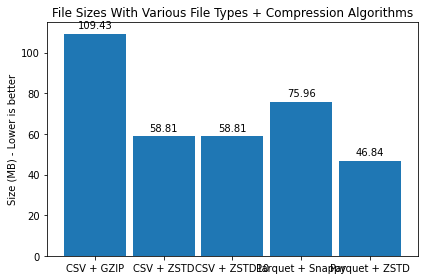

In [21]:
plt.figure()

x_labels = ['CSV + GZIP', 'CSV + ZSTD', 'CSV + ZSTD10','Parquet + Snappy', 'Parquet + ZSTD']
y_sizes = [csv_gzip_size, csv_zstd_size, csv_zstd10_size, parquet_snappy_size, parquet_zstd_size]
size_converter = lambda size: round(size/(1024*1024), 2)

y_sizes = [size_converter(size) for size in y_sizes]


x = np.arange(len(x_labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(x, y_sizes, width+0.45)

ax.set_ylabel('Size (MB) - Lower is better')
ax.set_title('File + Compression Type')
ax.set_xticks(x, x_labels)

ax.bar_label(rects, padding=3)

fig.tight_layout()

plt.title('File Sizes With Various File Types + Compression Algorithms')
plt.show()

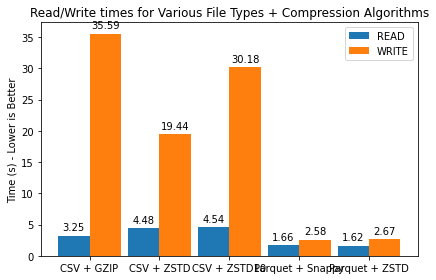

In [23]:
fig, ax = plt.subplots()

read_time = [csv_gzip_read_time, csv_zstd_read_time, csv_zstd10_read_time, parquet_snappy_read_time, parquet_zstd_read_time]
# write_time = [csv_gzip_write_time, csv_zstd_write_time, snappy_write_time, zst_parquet_write_time]
write_time = [csv_gzip_write_time, csv_zstd_write_time, csv_zstd10_write_time, parquet_snappy_write_time, parquet_zstd_write_time]

rects1 = ax.bar(x - width/2, read_time, width, label='READ')
rects2 = ax.bar(x + width/2, write_time, width, label='WRITE')

ax.set_ylabel('Time (s) - Lower is Better')
ax.set_title('Operation')
ax.set_xticks(x, x_labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.title('Read/Write times for Various File Types + Compression Algorithms')
plt.show()

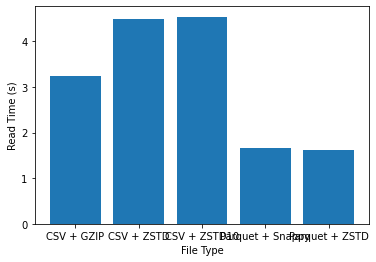

In [24]:
plt.bar(x_labels, read_time)
plt.xlabel('File Type')
plt.ylabel('Read Time (s)')

plt.show()

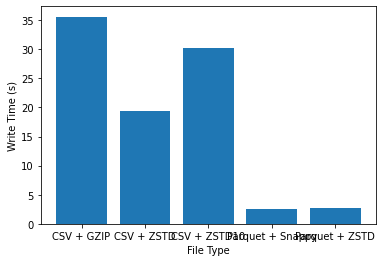

In [25]:
plt.bar(x_labels, write_time)
plt.xlabel('File Type')
plt.ylabel('Write Time (s)')

plt.show()